In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
import pandas as pd
import os
from matplotlib import font_manager, rc
from scipy.stats import multivariate_normal as mvn
import scipy as sp

from scipy import linalg

from sklearn.cluster import KMeans
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
csfont = {'fontname':'Times New Roman'}

## References

https://github.com/AlexanderFabisch/gmr

https://towardsdatascience.com/gaussian-mixture-modelling-gmm-833c88587c7f

https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

http://norman3.github.io/prml/docs/chapter09/2



## Load Data

In [3]:
####################################################################10F
weight = 52.6636363636364

# Get outputs
result1 = pd.read_csv('10F_arm_flex_90_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 
result_test = pd.read_csv('10F_arm_flex_120_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0)
result2 = pd.read_csv('10F_arm_flex_240_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 

# Get inputs
input1_10f = pd.read_csv('arm_flex_90_10_F.csv', sep=',',header=None).dropna(axis=0)
input_test_10f = pd.read_csv('arm_flex_120_10_F.csv', sep=',',header=None).dropna(axis=0)
input2_10f = pd.read_csv('arm_flex_240_10_F.csv', sep=',',header=None).dropna(axis=0)

input1_10f.iloc[:,0] = pd.DataFrame(np.ones((len(input1_10f), 1)))*90
input_test_10f.iloc[:,0] = pd.DataFrame(np.ones((len(input_test_10f), 1)))*120
input2_10f.iloc[:,0] = pd.DataFrame(np.ones((len(input2_10f), 1)))*240
# set index
new_header = result1.iloc[0]
result1 = result1[1:]
result_test = result_test[1:]
result2 = result2[1:]
result1.columns = new_header
result_test.columns = new_header
result2.columns = new_header

# add muscle values (PECM, LAT)
result1 = result1.astype('float64')/weight
result_test = result_test.astype('float64')/weight
result2 = result2.astype('float64')/weight
result1['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['PECM1'].astype(float)**2 + result1['PECM2'].astype(float)**2 + 
                                 result1['PECM3'].astype(float)**2), axis = 1)))
result_test['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['PECM1'].astype(float)**2 + result_test['PECM2'].astype(float)**2 + 
                                 result_test['PECM3'].astype(float)**2), axis = 1)))
result2['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['PECM1'].astype(float)**2 + result2['PECM2'].astype(float)**2 + 
                                 result2['PECM3'].astype(float)**2), axis = 1)))
result1['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['LAT1'].astype(float)**2 + result1['LAT2'].astype(float)**2 + 
                                 result1['LAT3'].astype(float)**2), axis = 1)))
result_test['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['LAT1'].astype(float)**2 + result_test['LAT2'].astype(float)**2 + 
                                 result_test['LAT3'].astype(float)**2), axis = 1)))
result2['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['LAT1'].astype(float)**2 + result2['LAT2'].astype(float)**2 + 
                                 result2['LAT3'].astype(float)**2), axis = 1)))

# rename indexes
result1.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result_test.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result2.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)

# select muscles
result1_10f = result1.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result_test_10f = result_test.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_10f = result2.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]

####################################################################10M
weight = 71.275

# Get outputs
result1 = pd.read_csv('10M_arm_flex_90_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 
result_test = pd.read_csv('10M_arm_flex_120_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0)
result2 = pd.read_csv('10M_arm_flex_240_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 

# Get inputs
input1_10m = pd.read_csv('arm_flex_90_10_M.csv', sep=',',header=None).dropna(axis=0)
input_test_10m = pd.read_csv('arm_flex_120_10_M.csv', sep=',',header=None).dropna(axis=0)
input2_10m = pd.read_csv('arm_flex_240_10_M.csv', sep=',',header=None).dropna(axis=0)


input1_10m.iloc[:,0] = pd.DataFrame(np.ones((len(input1_10m), 1)))*90
input_test_10m.iloc[:,0] = pd.DataFrame(np.ones((len(input_test_10m), 1)))*120
input2_10m.iloc[:,0] = pd.DataFrame(np.ones((len(input2_10m), 1)))*240
# set index
new_header = result1.iloc[0]
result1 = result1[1:]
result_test = result_test[1:]
result2 = result2[1:]
result1.columns = new_header
result_test.columns = new_header
result2.columns = new_header

# add muscle values (PECM, LAT)
result1 = result1.astype('float64')/weight
result_test = result_test.astype('float64')/weight
result2 = result2.astype('float64')/weight
result1['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['PECM1'].astype(float)**2 + result1['PECM2'].astype(float)**2 + 
                                 result1['PECM3'].astype(float)**2), axis = 1)))
result_test['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['PECM1'].astype(float)**2 + result_test['PECM2'].astype(float)**2 + 
                                 result_test['PECM3'].astype(float)**2), axis = 1)))
result2['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['PECM1'].astype(float)**2 + result2['PECM2'].astype(float)**2 + 
                                 result2['PECM3'].astype(float)**2), axis = 1)))
result1['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['LAT1'].astype(float)**2 + result1['LAT2'].astype(float)**2 + 
                                 result1['LAT3'].astype(float)**2), axis = 1)))
result_test['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['LAT1'].astype(float)**2 + result_test['LAT2'].astype(float)**2 + 
                                 result_test['LAT3'].astype(float)**2), axis = 1)))
result2['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['LAT1'].astype(float)**2 + result2['LAT2'].astype(float)**2 + 
                                 result2['LAT3'].astype(float)**2), axis = 1)))

# rename indexes
result1.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result_test.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result2.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)

# select muscles
result1_10m = result1.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result_test_10m = result_test.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_10m = result2.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_10m = result2_10m.loc[15:214,:]

#################################################################### 20F
weight = 53.56153846

# Get outputs
result1 = pd.read_csv('20F_arm_flex_90_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 
result_test = pd.read_csv('20F_arm_flex_120_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0)
result2 = pd.read_csv('20F_arm_flex_240_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 

# Get inputs
input1_20f = pd.read_csv('arm_flex_90_20_F.csv', sep=',',header=None).dropna(axis=0)
input_test_20f = pd.read_csv('arm_flex_120_20_F.csv', sep=',',header=None).dropna(axis=0)
input2_20f = pd.read_csv('arm_flex_240_20_F.csv', sep=',',header=None).dropna(axis=0)

input1_20f.iloc[:,0] = pd.DataFrame(np.ones((len(input1_20f), 1)))*90
input_test_20f.iloc[:,0] = pd.DataFrame(np.ones((len(input_test_20f), 1)))*120
input2_20f.iloc[:,0] = pd.DataFrame(np.ones((len(input2_20f), 1)))*240

# set index
new_header = result1.iloc[0]
result1 = result1[1:]
result_test = result_test[1:]
result2 = result2[1:]
result1.columns = new_header
result_test.columns = new_header
result2.columns = new_header

# add muscle values (PECM, LAT)
result1 = result1.astype('float64')/weight
result_test = result_test.astype('float64')/weight
result2 = result2.astype('float64')/weight
result1['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['PECM1'].astype(float)**2 + result1['PECM2'].astype(float)**2 + 
                                 result1['PECM3'].astype(float)**2), axis = 1)))
result_test['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['PECM1'].astype(float)**2 + result_test['PECM2'].astype(float)**2 + 
                                 result_test['PECM3'].astype(float)**2), axis = 1)))
result2['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['PECM1'].astype(float)**2 + result2['PECM2'].astype(float)**2 + 
                                 result2['PECM3'].astype(float)**2), axis = 1)))
result1['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['LAT1'].astype(float)**2 + result1['LAT2'].astype(float)**2 + 
                                 result1['LAT3'].astype(float)**2), axis = 1)))
result_test['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['LAT1'].astype(float)**2 + result_test['LAT2'].astype(float)**2 + 
                                 result_test['LAT3'].astype(float)**2), axis = 1)))
result2['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['LAT1'].astype(float)**2 + result2['LAT2'].astype(float)**2 + 
                                 result2['LAT3'].astype(float)**2), axis = 1)))
# rename indexes
result1.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result_test.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result2.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)

# select muscles
result1_20f = result1.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result_test_20f = result_test.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_20f = result2.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_20f = result2_20f.loc[15:214,:]

#################################################################### 20M
weight = 78.32631579

# Get outputs
result1 = pd.read_csv('20M_arm_flex_90_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 
result_test = pd.read_csv('20M_arm_flex_120_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0)
result2 = pd.read_csv('20M_arm_flex_240_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 

# Get inputs
input1_20m = pd.read_csv('arm_flex_90_20_M.csv', sep=',',header=None).dropna(axis=0)
input_test_20m = pd.read_csv('arm_flex_120_20_M.csv', sep=',',header=None).dropna(axis=0)
input2_20m = pd.read_csv('arm_flex_240_20_M.csv', sep=',',header=None).dropna(axis=0)

input1_20m.iloc[:,0] = pd.DataFrame(np.ones((len(input1_20m), 1)))*90
input_test_20m.iloc[:,0] = pd.DataFrame(np.ones((len(input_test_20m), 1)))*120
input2_20m.iloc[:,0] = pd.DataFrame(np.ones((len(input2_20m), 1)))*240
# set index
new_header = result1.iloc[0]
result1 = result1[1:]
result_test = result_test[1:]
result2 = result2[1:]
result1.columns = new_header
result_test.columns = new_header
result2.columns = new_header

# add muscle values (PECM, LAT)
result1 = result1.astype('float64')/weight
result_test = result_test.astype('float64')/weight
result2 = result2.astype('float64')/weight
result1['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['PECM1'].astype(float)**2 + result1['PECM2'].astype(float)**2 + 
                                 result1['PECM3'].astype(float)**2), axis = 1)))
result_test['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['PECM1'].astype(float)**2 + result_test['PECM2'].astype(float)**2 + 
                                 result_test['PECM3'].astype(float)**2), axis = 1)))
result2['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['PECM1'].astype(float)**2 + result2['PECM2'].astype(float)**2 + 
                                 result2['PECM3'].astype(float)**2), axis = 1)))
result1['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['LAT1'].astype(float)**2 + result1['LAT2'].astype(float)**2 + 
                                 result1['LAT3'].astype(float)**2), axis = 1)))
result_test['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['LAT1'].astype(float)**2 + result_test['LAT2'].astype(float)**2 + 
                                 result_test['LAT3'].astype(float)**2), axis = 1)))
result2['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['LAT1'].astype(float)**2 + result2['LAT2'].astype(float)**2 + 
                                 result2['LAT3'].astype(float)**2), axis = 1)))

# rename indexes
result1.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result_test.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result2.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)

# select muscles
result1_20m = result1.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result_test_20m = result_test.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_20m = result2.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_20m = result2_20m.loc[15:214,:]
result_test_20m = result_test_20m.loc[15:214,:]

#################################################################### 30F
weight = 60.98

# Get outputs
result1 = pd.read_csv('30F_arm_flex_90_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 
result_test = pd.read_csv('30F_arm_flex_120_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0)
result2 = pd.read_csv('30F_arm_flex_240_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 

# Get inputs
input1_30f = pd.read_csv('arm_flex_90_30_F.csv', sep=',',header=None).dropna(axis=0)
input_test_30f = pd.read_csv('arm_flex_120_30_F.csv', sep=',',header=None).dropna(axis=0)
input2_30f = pd.read_csv('arm_flex_240_30_F.csv', sep=',',header=None).dropna(axis=0)

input1_30f.iloc[:,0] = pd.DataFrame(np.ones((len(input1_30f), 1)))*90
input_test_30f.iloc[:,0] = pd.DataFrame(np.ones((len(input_test_30f), 1)))*120
input2_30f.iloc[:,0] = pd.DataFrame(np.ones((len(input2_30f), 1)))*240

# set index
new_header = result1.iloc[0]
result1 = result1[1:]
result_test = result_test[1:]
result2 = result2[1:]
result1.columns = new_header
result_test.columns = new_header
result2.columns = new_header

# add muscle values (PECM, LAT)
result1 = result1.astype('float64')/weight
result_test = result_test.astype('float64')/weight
result2 = result2.astype('float64')/weight
result1['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['PECM1'].astype(float)**2 + result1['PECM2'].astype(float)**2 + 
                                 result1['PECM3'].astype(float)**2), axis = 1)))
result_test['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['PECM1'].astype(float)**2 + result_test['PECM2'].astype(float)**2 + 
                                 result_test['PECM3'].astype(float)**2), axis = 1)))
result2['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['PECM1'].astype(float)**2 + result2['PECM2'].astype(float)**2 + 
                                 result2['PECM3'].astype(float)**2), axis = 1)))
result1['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['LAT1'].astype(float)**2 + result1['LAT2'].astype(float)**2 + 
                                 result1['LAT3'].astype(float)**2), axis = 1)))
result_test['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['LAT1'].astype(float)**2 + result_test['LAT2'].astype(float)**2 + 
                                 result_test['LAT3'].astype(float)**2), axis = 1)))
result2['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['LAT1'].astype(float)**2 + result2['LAT2'].astype(float)**2 + 
                                 result2['LAT3'].astype(float)**2), axis = 1)))

# rename indexes
result1.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result_test.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result2.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)

# select muscles
result1_30f = result1.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result_test_30f = result_test.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_30f = result2.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_30f = result2_30f.loc[15:214,:]

#################################################################### 30M
weight = 80.1

# Get outputs
result1 = pd.read_csv('30M_arm_flex_90_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 
result_test = pd.read_csv('30M_arm_flex_120_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0)
result2 = pd.read_csv('30M_arm_flex_240_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 

# Get inputs
input1_30m = pd.read_csv('arm_flex_90_30_M.csv', sep=',',header=None).dropna(axis=0)
input_test_30m = pd.read_csv('arm_flex_120_30_M.csv', sep=',',header=None).dropna(axis=0)
input2_30m = pd.read_csv('arm_flex_240_30_M.csv', sep=',',header=None).dropna(axis=0)

input1_30m.iloc[:,0] = pd.DataFrame(np.ones((len(input1_30m), 1)))*90
input_test_30m.iloc[:,0] = pd.DataFrame(np.ones((len(input_test_30m), 1)))*120
input2_30m.iloc[:,0] = pd.DataFrame(np.ones((len(input2_30m), 1)))*240
# set index
new_header = result1.iloc[0]
result1 = result1[1:]
result_test = result_test[1:]
result2 = result2[1:]
result1.columns = new_header
result_test.columns = new_header
result2.columns = new_header

# add muscle values (PECM, LAT)
result1 = result1.astype('float64')/weight
result_test = result_test.astype('float64')/weight
result2 = result2.astype('float64')/weight
result1['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['PECM1'].astype(float)**2 + result1['PECM2'].astype(float)**2 + 
                                 result1['PECM3'].astype(float)**2), axis = 1)))
result_test['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['PECM1'].astype(float)**2 + result_test['PECM2'].astype(float)**2 + 
                                 result_test['PECM3'].astype(float)**2), axis = 1)))
result2['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['PECM1'].astype(float)**2 + result2['PECM2'].astype(float)**2 + 
                                 result2['PECM3'].astype(float)**2), axis = 1)))
result1['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['LAT1'].astype(float)**2 + result1['LAT2'].astype(float)**2 + 
                                 result1['LAT3'].astype(float)**2), axis = 1)))
result_test['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['LAT1'].astype(float)**2 + result_test['LAT2'].astype(float)**2 + 
                                 result_test['LAT3'].astype(float)**2), axis = 1)))
result2['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['LAT1'].astype(float)**2 + result2['LAT2'].astype(float)**2 + 
                                 result2['LAT3'].astype(float)**2), axis = 1)))

# rename indexes
result1.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result_test.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result2.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)

# select muscles
result1_30m = result1.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result_test_30m = result_test.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_30m = result2.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_30m = result2_30m.loc[15:214,:]

#################################################################### 40F
weight = 56.60909091

# Get outputs
result1 = pd.read_csv('40F_arm_flex_90_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 
result_test = pd.read_csv('40F_arm_flex_120_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0)
result2 = pd.read_csv('40F_arm_flex_240_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 

# Get inputs
input1_40f = pd.read_csv('arm_flex_90_40_F.csv', sep=',',header=None).dropna(axis=0)
input_test_40f = pd.read_csv('arm_flex_120_40_F.csv', sep=',',header=None).dropna(axis=0)
input2_40f = pd.read_csv('arm_flex_240_40_F.csv', sep=',',header=None).dropna(axis=0)

input1_40f.iloc[:,0] = pd.DataFrame(np.ones((len(input1_40f), 1)))*90
input_test_40f.iloc[:,0] = pd.DataFrame(np.ones((len(input_test_40f), 1)))*120
input2_40f.iloc[:,0] = pd.DataFrame(np.ones((len(input2_40f), 1)))*240

# set index
new_header = result1.iloc[0]
result1 = result1[1:]
result_test = result_test[1:]
result2 = result2[1:]
result1.columns = new_header
result_test.columns = new_header
result2.columns = new_header

# add muscle values (PECM, LAT)
result1 = result1.astype('float64')/weight
result_test = result_test.astype('float64')/weight
result2 = result2.astype('float64')/weight
result1['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['PECM1'].astype(float)**2 + result1['PECM2'].astype(float)**2 + 
                                 result1['PECM3'].astype(float)**2), axis = 1)))
result_test['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['PECM1'].astype(float)**2 + result_test['PECM2'].astype(float)**2 + 
                                 result_test['PECM3'].astype(float)**2), axis = 1)))
result2['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['PECM1'].astype(float)**2 + result2['PECM2'].astype(float)**2 + 
                                 result2['PECM3'].astype(float)**2), axis = 1)))
result1['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['LAT1'].astype(float)**2 + result1['LAT2'].astype(float)**2 + 
                                 result1['LAT3'].astype(float)**2), axis = 1)))
result_test['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['LAT1'].astype(float)**2 + result_test['LAT2'].astype(float)**2 + 
                                 result_test['LAT3'].astype(float)**2), axis = 1)))
result2['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['LAT1'].astype(float)**2 + result2['LAT2'].astype(float)**2 + 
                                 result2['LAT3'].astype(float)**2), axis = 1)))
# rename indexes
result1.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result_test.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result2.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)

# select muscles
result1_40f = result1.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result_test_40f = result_test.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_40f = result2.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_40f = result2_40f.loc[15:214,:]

#################################################################### 40M
weight = 82.08571429

# Get outputs
result1 = pd.read_csv('40M_arm_flex_90_StaticOptimization_force.csv', sep=',',header=None).dropna(axis=0) 
result_test = pd.read_csv('40M_arm_flex_120_StaticOptimization_force.csv', sep=',',header=None).dropna(axis=0)
result2 = pd.read_csv('40M_arm_flex_240_StaticOptimization_force.csv', sep=',',header=None).dropna(axis=0) 

# Get inputs
input1_40m = pd.read_csv('arm_flex_90_40_M.csv', sep=',',header=None).dropna(axis=0)
input_test_40m = pd.read_csv('arm_flex_120_40_M.csv', sep=',',header=None).dropna(axis=0)
input2_40m = pd.read_csv('arm_flex_240_40_M.csv', sep=',',header=None).dropna(axis=0)

input1_40m.iloc[:,0] = pd.DataFrame(np.ones((len(input1_40m), 1)))*90
input_test_40m.iloc[:,0] = pd.DataFrame(np.ones((len(input_test_40m), 1)))*120
input2_40m.iloc[:,0] = pd.DataFrame(np.ones((len(input2_40m), 1)))*240

# set index
new_header = result1.iloc[0]
result1 = result1[1:]
result_test = result_test[1:]
result2 = result2[1:]
result1.columns = new_header
result_test.columns = new_header
result2.columns = new_header

# add muscle values (PECM, LAT)
result1 = result1.astype('float64')/weight
result_test = result_test.astype('float64')/weight
result2 = result2.astype('float64')/weight
result1['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['PECM1'].astype(float)**2 + result1['PECM2'].astype(float)**2 + 
                                 result1['PECM3'].astype(float)**2), axis = 1)))
result_test['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['PECM1'].astype(float)**2 + result_test['PECM2'].astype(float)**2 + 
                                 result_test['PECM3'].astype(float)**2), axis = 1)))
result2['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['PECM1'].astype(float)**2 + result2['PECM2'].astype(float)**2 + 
                                 result2['PECM3'].astype(float)**2), axis = 1)))
result1['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['LAT1'].astype(float)**2 + result1['LAT2'].astype(float)**2 + 
                                 result1['LAT3'].astype(float)**2), axis = 1)))
result_test['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['LAT1'].astype(float)**2 + result_test['LAT2'].astype(float)**2 + 
                                 result_test['LAT3'].astype(float)**2), axis = 1)))
result2['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['LAT1'].astype(float)**2 + result2['LAT2'].astype(float)**2 + 
                                 result2['LAT3'].astype(float)**2), axis = 1)))
# rename indexes
result1.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result_test.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result2.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)

# select muscles
result1_40m = result1.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result_test_40m = result_test.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_40m = result2.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_40m = result2_40m.loc[15:214,:]

#################################################################### 50F
weight = 65.1

# Get outputs
result1 = pd.read_csv('50F_arm_flex_90_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 
result_test = pd.read_csv('50F_arm_flex_120_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0)
result2 = pd.read_csv('50F_arm_flex_240_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 

# Get inputs
input1_50f = pd.read_csv('arm_flex_90_50_F.csv', sep=',',header=None).dropna(axis=0)
input_test_50f = pd.read_csv('arm_flex_120_50_F.csv', sep=',',header=None).dropna(axis=0)
input2_50f = pd.read_csv('arm_flex_240_50_F.csv', sep=',',header=None).dropna(axis=0)

input1_50f.iloc[:,0] = pd.DataFrame(np.ones((len(input1_50f), 1)))*90
input_test_50f.iloc[:,0] = pd.DataFrame(np.ones((len(input_test_50f), 1)))*120
input2_50f.iloc[:,0] = pd.DataFrame(np.ones((len(input2_50f), 1)))*240

# set index
new_header = result1.iloc[0]
result1 = result1[1:]
result_test = result_test[1:]
result2 = result2[1:]
result1.columns = new_header
result_test.columns = new_header
result2.columns = new_header

# add muscle values (PECM, LAT)
result1 = result1.astype('float64')/weight
result_test = result_test.astype('float64')/weight
result2 = result2.astype('float64')/weight
result1['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['PECM1'].astype(float)**2 + result1['PECM2'].astype(float)**2 + 
                                 result1['PECM3'].astype(float)**2), axis = 1)))
result_test['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['PECM1'].astype(float)**2 + result_test['PECM2'].astype(float)**2 + 
                                 result_test['PECM3'].astype(float)**2), axis = 1)))
result2['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['PECM1'].astype(float)**2 + result2['PECM2'].astype(float)**2 + 
                                 result2['PECM3'].astype(float)**2), axis = 1)))
result1['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['LAT1'].astype(float)**2 + result1['LAT2'].astype(float)**2 + 
                                 result1['LAT3'].astype(float)**2), axis = 1)))
result_test['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['LAT1'].astype(float)**2 + result_test['LAT2'].astype(float)**2 + 
                                 result_test['LAT3'].astype(float)**2), axis = 1)))
result2['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['LAT1'].astype(float)**2 + result2['LAT2'].astype(float)**2 + 
                                 result2['LAT3'].astype(float)**2), axis = 1)))

# rename indexes
result1.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result_test.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result2.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)

# select muscles
result1_50f = result1.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result_test_50f = result_test.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_50f = result2.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_50f = result2_50f.loc[15:214,:]

#################################################################### 50M
weight = 88.35

# Get outputs
result1 = pd.read_csv('50M_arm_flex_90_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 
result_test = pd.read_csv('50M_arm_flex_120_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0)
result2 = pd.read_csv('50M_arm_flex_240_StaticOptimization_force.sto.csv', sep=',',header=None).dropna(axis=0) 

# Get inputs
input1_50m = pd.read_csv('arm_flex_90_50_M.csv', sep=',',header=None).dropna(axis=0)
input_test_50m = pd.read_csv('arm_flex_120_50_M.csv', sep=',',header=None).dropna(axis=0)
input2_50m = pd.read_csv('arm_flex_240_50_M.csv', sep=',',header=None).dropna(axis=0)

input1_50m.iloc[:,0] = pd.DataFrame(np.ones((len(input1_50m), 1)))*90
input_test_50m.iloc[:,0] = pd.DataFrame(np.ones((len(input_test_50m), 1)))*120
input2_50m.iloc[:,0] = pd.DataFrame(np.ones((len(input2_50m), 1)))*240
# set index
new_header = result1.iloc[0]
result1 = result1[1:]
result_test = result_test[1:]
result2 = result2[1:]
result1.columns = new_header
result_test.columns = new_header
result2.columns = new_header

# add muscle values (PECM, LAT)
result1 = result1.astype('float64')/weight
result_test = result_test.astype('float64')/weight
result2 = result2.astype('float64')/weight
result1['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['PECM1'].astype(float)**2 + result1['PECM2'].astype(float)**2 + 
                                 result1['PECM3'].astype(float)**2), axis = 1)))
result_test['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['PECM1'].astype(float)**2 + result_test['PECM2'].astype(float)**2 + 
                                 result_test['PECM3'].astype(float)**2), axis = 1)))
result2['PECM1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['PECM1'].astype(float)**2 + result2['PECM2'].astype(float)**2 + 
                                 result2['PECM3'].astype(float)**2), axis = 1)))
result1['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result1['LAT1'].astype(float)**2 + result1['LAT2'].astype(float)**2 + 
                                 result1['LAT3'].astype(float)**2), axis = 1)))
result_test['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result_test['LAT1'].astype(float)**2 + result_test['LAT2'].astype(float)**2 + 
                                 result_test['LAT3'].astype(float)**2), axis = 1)))
result2['LAT1'] = pd.DataFrame(np.sqrt(np.sum(pd.DataFrame(result2['LAT1'].astype(float)**2 + result2['LAT2'].astype(float)**2 + 
                                 result2['LAT3'].astype(float)**2), axis = 1)))

# rename indexes
result1.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result_test.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)
result2.rename(columns={'PECM1': 'PECM', 'LAT1': 'LAT'}, inplace=True)

# select muscles
result1_50m = result1.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result_test_50m = result_test.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_50m = result2.loc[:,['DELT1','DELT3','SUPSP','INFSP','PECM','LAT','TRImed','BIClong']]
result2_50m = result2_50m.loc[15:214,:]

####################################################################
# 10F
train_input1_10f = input1_10f.values
train_input2_10f = input2_10f.values
train_output1_10f = result1_10f.values
train_output2_10f = result2_10f.values
train_X_10f = np.concatenate((train_input1_10f, train_input2_10f), axis = 0)
train_Y_10f = np.concatenate((train_output1_10f, train_output2_10f), axis = 0)
test_input_10f = input_test_10f.values
test_output_10f = result_test_10f.values

# 10M
train_input1_10m = input1_10m.values
train_input2_10m = input2_10m.values
train_output1_10m = result1_10m.values
train_output2_10m = result2_10m.values
train_X_10m = np.concatenate((train_input1_10m, train_input2_10m), axis = 0)
train_Y_10m = np.concatenate((train_output1_10m, train_output2_10m), axis = 0)
test_input_10m = input_test_10m.values
test_output_10m = result_test_10m.values

# 20F
train_input1_20f = input1_20f.values
train_input2_20f = input2_20f.values
train_output1_20f = result1_20f.values
train_output2_20f = result2_20f.values
train_X_20f = np.concatenate((train_input1_20f, train_input2_20f), axis = 0)
train_Y_20f = np.concatenate((train_output1_20f, train_output2_20f), axis = 0)
test_input_20f = input_test_20f.values
test_output_20f = result_test_20f.values

# 20M
train_input1_20m = input1_20m.values
train_input2_20m = input2_20m.values
train_output1_20m = result1_20m.values
train_output2_20m = result2_20m.values
train_X_20m = np.concatenate((train_input1_20m, train_input2_20m), axis = 0)
train_Y_20m = np.concatenate((train_output1_20m, train_output2_20m), axis = 0)
test_input_20m = input_test_20m.values
test_output_20m = result_test_20m.values

# 30F
train_input1_30f = input1_30f.values
train_input2_30f = input2_30f.values
train_output1_30f = result1_30f.values
train_output2_30f = result2_30f.values
train_X_30f = np.concatenate((train_input1_30f, train_input2_30f), axis = 0)
train_Y_30f = np.concatenate((train_output1_30f, train_output2_30f), axis = 0)
test_input_30f = input_test_30f.values
test_output_30f = result_test_30f.values

# 30M
train_input1_30m = input1_30m.values
train_input2_30m = input2_30m.values
train_output1_30m = result1_30m.values
train_output2_30m = result2_30m.values
train_X_30m = np.concatenate((train_input1_30m, train_input2_30m), axis = 0)
train_Y_30m = np.concatenate((train_output1_30m, train_output2_30m), axis = 0)
test_input_30m = input_test_30m.values
test_output_30m = result_test_30m.values

# 40F
train_input1_40f = input1_40f.values
train_input2_40f = input2_40f.values
train_output1_40f = result1_40f.values
train_output2_40f = result2_40f.values
train_X_40f = np.concatenate((train_input1_40f, train_input2_40f), axis = 0)
train_Y_40f = np.concatenate((train_output1_40f, train_output2_40f), axis = 0)
test_input_40f = input_test_40f.values
test_output_40f = result_test_40f.values

# 40M
train_input1_40m = input1_40m.values
train_input2_40m = input2_40m.values
train_output1_40m = result1_40m.values
train_output2_40m = result2_40m.values
train_X_40m = np.concatenate((train_input1_40m, train_input2_40m), axis = 0)
train_Y_40m = np.concatenate((train_output1_40m, train_output2_40m), axis = 0)
test_input_40m = input_test_40m.values
test_output_40m = result_test_40m.values

# 50F
train_input1_50f = input1_50f.values
train_input2_50f = input2_50f.values
train_output1_50f = result1_50f.values
train_output2_50f = result2_50f.values
train_X_50f = np.concatenate((train_input1_50f, train_input2_50f), axis = 0)
train_Y_50f = np.concatenate((train_output1_50f, train_output2_50f), axis = 0)
test_input_50f = input_test_50f.values
test_output_50f = result_test_50f.values

# 50M
train_input1_50m = input1_50m.values
train_input2_50m = input2_50m.values
train_output1_50m = result1_50m.values
train_output2_50m = result2_50m.values
train_X_50m = np.concatenate((train_input1_50m, train_input2_50m), axis = 0)
train_Y_50m = np.concatenate((train_output1_50m, train_output2_50m), axis = 0)
test_input_50m = input_test_50m.values
test_output_50m = result_test_50m.values

train_input1_10f[:,1] = train_input1_10f[:,1]-train_input1_10f[0,1]
train_input1_20f[:,1] = train_input1_20f[:,1]-train_input1_20f[0,1]
train_input1_30f[:,1] = train_input1_30f[:,1]-train_input1_30f[0,1]
train_input1_40f[:,1] = train_input1_40f[:,1]-train_input1_40f[0,1]
train_input1_50f[:,1] = train_input1_50f[:,1]-train_input1_50f[0,1]

train_input2_10f[:,1] = train_input2_10f[:,1]-train_input2_10f[0,1]
train_input2_20f[:,1] = train_input2_20f[:,1]-train_input2_20f[0,1]
train_input2_30f[:,1] = train_input2_30f[:,1]-train_input2_30f[0,1]
train_input2_40f[:,1] = train_input2_40f[:,1]-train_input2_40f[0,1]
train_input2_50f[:,1] = train_input2_50f[:,1]-train_input2_50f[0,1]

test_input_10f[:,1] = test_input_10f[:,1]-test_input_10f[0,1]
test_input_20f[:,1] = test_input_20f[:,1]-test_input_20f[0,1]
test_input_30f[:,1] = test_input_30f[:,1]-test_input_30f[0,1]
test_input_40f[:,1] = test_input_40f[:,1]-test_input_40f[0,1]
test_input_50f[:,1] = test_input_50f[:,1]-test_input_50f[0,1]

train_input1_10m[:,1] = train_input1_10m[:,1]-train_input1_10m[0,1]
train_input1_20m[:,1] = train_input1_20m[:,1]-train_input1_20m[0,1]
train_input1_30m[:,1] = train_input1_30m[:,1]-train_input1_30m[0,1]
train_input1_40m[:,1] = train_input1_40m[:,1]-train_input1_40m[0,1]
train_input1_50m[:,1] = train_input1_50m[:,1]-train_input1_50m[0,1]

train_input2_10m[:,1] = train_input2_10m[:,1]-train_input2_10m[0,1]
train_input2_20m[:,1] = train_input2_20m[:,1]-train_input2_20m[0,1]
train_input2_30m[:,1] = train_input2_30m[:,1]-train_input2_30m[0,1]
train_input2_40m[:,1] = train_input2_40m[:,1]-train_input2_40m[0,1]
train_input2_50m[:,1] = train_input2_50m[:,1]-train_input2_50m[0,1]

test_input_10m[:,1] = test_input_10m[:,1]-test_input_10m[0,1]
test_input_20m[:,1] = test_input_20m[:,1]-test_input_20m[0,1]
test_input_30m[:,1] = test_input_30m[:,1]-test_input_30m[0,1]
test_input_40m[:,1] = test_input_40m[:,1]-test_input_40m[0,1]
test_input_50m[:,1] = test_input_50m[:,1]-test_input_50m[0,1]

train_X_f = np.concatenate((train_input1_10f, train_input2_10f, train_input1_20f, train_input2_20f,
                         train_input1_30f, train_input2_30f, train_input1_40f, train_input2_40f,
                         train_input1_50f, train_input2_50f), axis = 0)
train_X_m = np.concatenate((train_input1_10m, train_input2_10m, train_input1_20m, train_input2_20m,
                         train_input1_30m, train_input2_30m, train_input1_40m, train_input2_40m,
                         train_input1_50m, train_input2_50m), axis = 0)
train_Y_f = np.concatenate((train_output1_10f, train_output2_10f, train_output1_20f, train_output2_20f,
                         train_output1_30f, train_output2_30f, train_output1_40f, train_output2_40f,
                         train_output1_50f, train_output2_50f), axis = 0)
train_Y_m = np.concatenate((train_output1_10m, train_output2_10m, train_output1_20m, train_output2_20m,
                         train_output1_30m, train_output2_30m, train_output1_40m, train_output2_40m,
                         train_output1_50m, train_output2_50m), axis = 0)
test_input_f = np.concatenate((input_test_10f.values, input_test_20f.values, input_test_30f.values,
                              input_test_40f.values, input_test_50f.values), axis = 0)
test_output_f = np.concatenate((result_test_10f.values, result_test_20f.values, result_test_30f.values,
                              result_test_40f.values, result_test_50f.values), axis = 0)
test_input_m = np.concatenate((input_test_10m.values, input_test_20m.values, input_test_30m.values,
                              input_test_40m.values, input_test_50m.values), axis = 0)
test_output_m = np.concatenate((result_test_10m.values, result_test_20m.values, result_test_30m.values,
                              result_test_40m.values, result_test_50m.values), axis = 0)

train_X_rand_f = np.concatenate((train_X_f, test_input_f), axis = 0)
train_Y_rand_f = np.concatenate((train_Y_f, test_output_f), axis = 0)

train_X_rand_m = np.concatenate((train_X_m, test_input_m), axis = 0)
train_Y_rand_m = np.concatenate((train_Y_m, test_output_m), axis = 0)

arm_flex_train_X_rand_f = train_X_rand_f
arm_flex_train_Y_rand_f = train_Y_rand_f
arm_flex_train_X_rand_m = train_X_rand_m
arm_flex_train_Y_rand_m = train_Y_rand_m

## GMM + GMR

In [53]:
class mvn_test(object):
    def __init__(self, mean=None, covariance=None):
        self.mean = mean
        self.covariance = covariance
        self.norm = None
    def make_mvn(self, X, bessels_correction=True):
        self.mean = np.mean(X, axis=0)
        bias = 0 if bessels_correction else 1
        self.covariance = np.cov(X, rowvar=0, bias=bias)
        self.norm = None
        return self
    
    def to_probability_density(self, X):
        X = np.atleast_2d(X)
        n_features = X.shape[1]

        C = self.covariance
        try:
            L = sp.linalg.cholesky(C, lower=True)
        except np.linalg.LinAlgError:
            C = self.covariance + 1e-6 * np.eye(n_features)
            L = sp.linalg.cholesky(C, lower=True)
        D = X - self.mean
        cov_sol = sp.linalg.solve_triangular(L, D.T, lower=True).T
        if self.norm is None:
            self.norm = 0.5 / np.pi ** (0.5 * n_features) / sp.linalg.det(L)

        DpD = np.sum(cov_sol ** 2, axis=1)
        return self.norm * np.exp(-0.5 * DpD)
    
    def marginalize(self, indices):
        return mvn_test(mean=self.mean[indices], covariance=self.covariance[np.ix_(indices, indices)])
    def _condition(self, i1, i2, X):
        cov_12 = self.covariance[np.ix_(i1, i2)]
        cov_11 = self.covariance[np.ix_(i1, i1)]
        cov_22 = self.covariance[np.ix_(i2, i2)]
        a = np.asarray_chkfinite(cov_22)
        s, u = linalg.eigh(a, lower=True)
        cond = None
        if cond in [None, -1]:
            t = u.dtype.char.lower()
            factor = {'f': 1E3, 'd': 1E6}
            cond = factor[t] * np.finfo(t).eps
        above_cutoff = (abs(s) > cond * np.max(abs(s)))
        psigma_diag = np.zeros_like(s)
        psigma_diag[above_cutoff] = 1.0 / s[above_cutoff]
        prec_22 = np.dot(u * psigma_diag, np.conjugate(u).T)
        regression_coeffs = cov_12.dot(prec_22)
        mean = self.mean[i1] + regression_coeffs.dot((X - self.mean[i2]).T).T
        covariance = cov_11 - regression_coeffs.dot(cov_12.T)
        return mean, covariance
    
    def condition(self, indices, x):
        inv = np.ones(self.mean.shape[0], dtype=np.bool)
        inv[indices] = False
        inv, = np.where(inv)
        mean, covariance = self._condition(inv, indices, x)
        return mvn_test(mean=mean, covariance=covariance)
    
    def condition_multiple(self, indices, X):
        inv = np.ones(self.mean.shape[0], dtype=np.bool)
        inv[indices] = False
        inv, = np.where(inv)
        return self._condition(inv, indices, X)
    
    def to_ellipse(self, factor=1.0):
        vals, vecs = sp.linalg.eigh(self.covariance)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        angle = np.arctan2(*vecs[:, 0][::-1])
        width, height = factor * np.sqrt(vals)
        return angle, width, height

In [54]:
class GMM:
    def __init__(self, n_clusters, n_iters):
        self.n_clusters = n_clusters 
        self.n_iters= n_iters
        
    def get_params(self):
        return (self.mean, self.pi, self.sigma)
    
    def initialize(self, X):
        n_clusters = self.n_clusters
        kmeans = KMeans(n_clusters= n_clusters, init="k-means++", max_iter=500, algorithm = 'auto')
        fitted = kmeans.fit(X)
        prediction = kmeans.predict(X)
        
        d = X.shape[1]
        labels = np.unique(prediction) 
        self.initial_means = np.zeros((self.n_clusters, d))
        self.initial_cov = np.zeros((self.n_clusters, d, d))
        self.initial_pi = np.zeros(self.n_clusters)
        
        counter=0
        for label in labels:
            ids = np.where(prediction == label) # returns indices
            self.initial_pi[counter] = len(ids[0]) / X.shape[0]
            self.initial_means[counter,:] = np.mean(X[ids], axis = 0)
            de_meaned = X[ids] - self.initial_means[counter,:]
            Nk = X[ids].shape[0] # number of data points in current gaussian
            self.initial_cov[counter,:, :] = np.dot(self.initial_pi[counter] * de_meaned.T, de_meaned) / Nk            
            counter+=1
        assert np.sum(self.initial_pi) == 1    
        return (self.initial_means, self.initial_cov, self.initial_pi)
    
    def _e_step(self, X, pi, mean, sigma):
        N = X.shape[0] 
        self.gamma = np.zeros((N, self.n_clusters))
        const_c = np.zeros(self.n_clusters)        
        self.mean = self.mean if self.initial_means is None else self.initial_means
        self.pi = self.pi if self.initial_pi is None else self.initial_pi
        self.sigma = self.sigma if self.initial_cov is None else self.initial_cov

        for c in range(self.n_clusters):
            # Posterior Distribution using Bayes Rule
            self.gamma[:,c] = self.pi[c] * mvn.pdf(X, self.mean[c,:], self.sigma[c])
        # normalize across columns to make a valid probability
        gamma_norm = np.sum(self.gamma, axis=1)[:,np.newaxis]
        self.gamma /= gamma_norm
        return self.gamma
    
    def _m_step(self, X, gamma):
        N = X.shape[0] # number of objects
        n_clusters = self.gamma.shape[1] # number of n_clusterss
        d = X.shape[1] # dimension of each object

        self.pi = np.mean(self.gamma, axis = 0)
        self.mean = np.dot(self.gamma.T, X) / np.sum(self.gamma, axis = 0)[:,np.newaxis]

        for c in range(n_clusters):
            x = X - self.mean[c, :] # (N x d)
            gamma_diag = np.diag(self.gamma[:,c]) # 1D array를 대각행렬로 만듬
            x_mean = np.matrix(x)
            gamma_diag = np.matrix(gamma_diag)
            sigma_c = x.T * gamma_diag * x
            self.sigma[c,:,:]=(sigma_c) / np.sum(self.gamma, axis = 0)[:,np.newaxis][c]
        return self.pi, self.mean, self.sigma
    
    
    def _compute_loss_function(self, X, pi, mean, sigma):
        # pi: (n_clusters), mean: (n_clusters x d), sigma: (n_clusters x d x d)

        N = X.shape[0]
        n_clusters = self.gamma.shape[1]
        self.loss = np.zeros((N, n_clusters))

        for c in range(n_clusters):
            dist = mvn(self.mean[c], self.sigma[c],allow_singular=True)
            self.loss[:,c] = self.gamma[:,c] * (np.log(self.pi[c]+0.00001)+dist.logpdf(X)-np.log(self.gamma[:,c]+0.000001))
        self.loss = np.sum(self.loss)
        return self.loss
    
    def fit(self, X):
        d = X.shape[1]
        self.mean, self.sigma, self.pi =  self.initialize(X)
        try:
            for run in range(self.n_iters):  
                self.gamma  = self._e_step(X, self.mean, self.pi, self.sigma)
                self.pi, self.mean, self.sigma = self._m_step(X, self.gamma)
                loss = self._compute_loss_function(X, self.pi, self.mean, self.sigma)
                if run % 10 == 0:
                    print("Iteration: %d Loss: %0.6f" %(run, loss))
        except Exception as e:
            print(e)
        return self
    
    def predict_labels(self, X):
        # labels: predicted n_clusters based on highest probability gamma
        labels = np.zeros((X.shape[0], self.n_clusters))
        for c in range(self.n_clusters):
            labels [:,c] = self.pi[c] * mvn.pdf(X, self.mean[c,:], self.sigma[c])
        post_proba = labels
        final_labels  = labels.argmax(1)
        return post_proba, final_labels 

    def cond_predict(self, indices, X):
        n_samples, n_features_1 = X.shape
        n_features_2 = self.mean.shape[1] - n_features_1
        Y = np.empty((n_samples, n_features_2))
        for n in range(n_samples):            
            x = X[n]
            n_features = self.mean.shape[1] - len(indices)
            priors = np.empty(self.n_clusters)
            means = np.empty((self.n_clusters, n_features))
            covariances = np.empty((self.n_clusters, n_features, n_features))
            for k in range(self.n_clusters):
                mvn = mvn_test(mean=self.mean[k], covariance=self.sigma[k])
                conditioned = mvn.condition(indices, x)
                priors[k] = (self.pi[k] * mvn.marginalize(indices).to_probability_density(x))
                means[k] = conditioned.mean
                covariances[k] = conditioned.covariance
            priors /= priors.sum()            
            Y[n] = priors.dot(means)
        return Y
   
    def to_ellipses(self, factor=1.0):
        res = []
        for k in range(self.n_clusters):
            mvn = mvn_test(mean=self.mean[k], covariance=self.sigma[k])
            res.append((self.mean[k], mvn.to_ellipse(factor)))
        return res
    
def plot_error_ellipses(ax, gmm, colors=None):
    from matplotlib.patches import Ellipse
    from itertools import cycle
    if colors is not None:
        colors = cycle(colors)
    for factor in np.linspace(0.5, 4.0, 8):
        for mean, (angle, width, height) in gmm.to_ellipses(factor):
            ell = Ellipse(xy=mean, width=width, height=height,
                          angle=np.degrees(angle))
            ell.set_alpha(0.25)
            if colors is not None:
                ell.set_color(next(colors))
            ax.add_artist(ell)

## Example (Arm flexion data)

In [77]:
test_120 = train_X_rand_f[np.arange(2000,3000),:]
test_90 = np.concatenate((train_input1_10f, train_input1_20f, train_input1_30f, train_input1_40f, train_input1_50f), axis = 0)
test_240 = np.concatenate((train_input2_10f, train_input2_20f, train_input2_30f, train_input2_40f, train_input2_50f), axis = 0)

print(test_90.shape, test_120.shape, test_240.shape)

test_90[:,0] = 90+np.arange(0, 0.01, 0.00001)
test_120[:,0] = 120+np.arange(0, 0.01, 0.00001)
test_240[:,0] = 240+np.arange(0, 0.01, 0.00001)

fit_data = np.concatenate((test_90, test_120, test_240), axis=0)
fit_data = fit_data[np.arange(0, 3000, 10),:]

model = GMM(3, 80)
fitted_values = model.fit(np.array(fit_data))

#pos_full = []
#for pos, covar, w in zip(model.mean, model.sigma, model.pi):
#    pos_full.extend(pos)
    #print(pos, covar)
    
centers = np.zeros((3,3))
for i in range(model.n_clusters):
    density = mvn(cov=model.sigma[i], mean=model.mean[i]).logpdf(fit_data)
    centers[i, :] = fit_data[np.argmax(density)]

(1000, 3) (1000, 3) (1000, 3)
Iteration: 0 Loss: -2506.975459
Iteration: 10 Loss: -2497.367602
Iteration: 20 Loss: -2497.363234
Iteration: 30 Loss: -2497.363237
Iteration: 40 Loss: -2497.363237
Iteration: 50 Loss: -2497.363237
Iteration: 60 Loss: -2497.363237
Iteration: 70 Loss: -2497.363237


Text(0.5,0,'Moment')

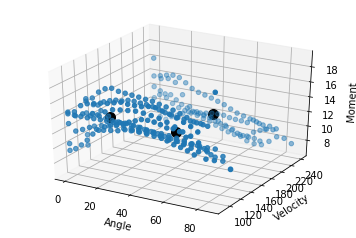

In [78]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
x = fit_data[:,1] # angle
y = fit_data[:,0] # velocity
z = fit_data[:,2] # torque
ax.scatter(x, y, z)
for i in np.arange(3):
    x = pos_full[i*3+1]
    y = pos_full[i*3]
    z = pos_full[i*3+2]
    ax.scatter(x,y,z,c='k',s=100)

ax.set_xlabel('Angle')
ax.set_ylabel('Velocity')
ax.set_zlabel('Moment')


Text(0.5,0,'Moment')

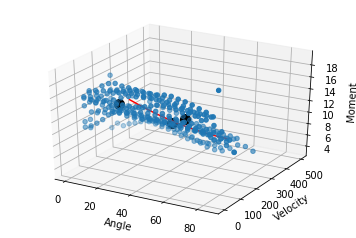

In [103]:
fig = plt.figure()

X_test = np.linspace(0, 500, 1000)
Y= model.cond_predict(np.array([0]), X_test[:, np.newaxis])

ax = fig.add_subplot(111, projection='3d')
x = fit_data[:,1] # angle
y = fit_data[:,0] # velocity
z = fit_data[:,2] # torque
ax.scatter(x, y, z)
for i in np.arange(3):
    x = pos_full[i*3+1]
    y = pos_full[i*3]
    z = pos_full[i*3+2]
    ax.scatter(x,y,z,c='k',s=100)
ax.plot(Y[:,0], X_test, Y[:,1], 'r')

ax.set_xlabel('Angle')
ax.set_ylabel('Velocity')
ax.set_zlabel('Moment')


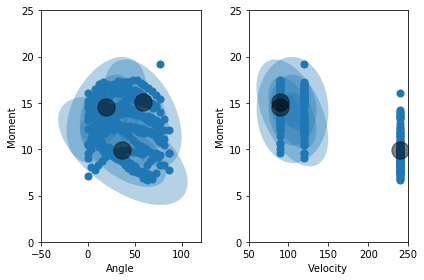

In [81]:
fig = plt.figure()

ax = fig.add_subplot(1, 2, 1)
ax.scatter(fit_data[:, 1], fit_data[:, 2],s=50, zorder=1)
ax.scatter(centers[:, 1], centers[:, 2],c='black', s=300, alpha=0.5, zorder=2)
w_factor = 0.2 / model.pi.max()
for pos, covar, w in zip(model.mean, model.sigma, model.pi):
    pos = pos[1:3]
    covar = covar[1:3,1:3]
    draw_ellipse(pos, covar, alpha = w)
ax.set_xlim((-50,120))
ax.set_ylim((0,25))
ax.set_xlabel('Angle')
ax.set_ylabel('Moment')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(fit_data[:, 0], fit_data[:, 2],s=50, zorder=1)
ax.scatter(centers[:, 0], centers[:, 2],c='black', s=300, alpha=0.5, zorder=2)

w_factor = 0.2 / model.pi.max()
for pos, covar, w in zip(model.mean, model.sigma, model.pi):
    pos = pos[[0,2]]
    covar = np.delete(covar, 1, 0)
    covar = np.delete(covar, 1, 1)    
    draw_ellipse(pos, covar, alpha = w)
    #print(pos, covar)
    
ax.set_xlim((50,250))
ax.set_ylim((0,25))
ax.set_xlabel('Velocity')
ax.set_ylabel('Moment')
fig.tight_layout()
plt.show()

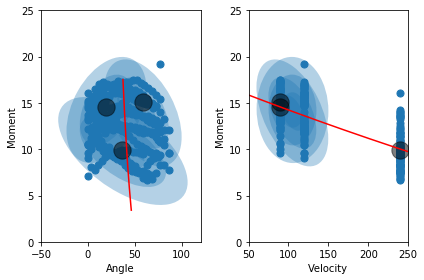

In [101]:
fig = plt.figure()

X_test = np.linspace(0, 500, 1000)
Y= model.cond_predict(np.array([0]), X_test[:, np.newaxis])

ax = fig.add_subplot(1, 2, 1)
ax.scatter(fit_data[:, 1], fit_data[:, 2],s=50, zorder=1)
ax.scatter(centers[:, 1], centers[:, 2],c='black', s=300, alpha=0.5, zorder=2)
ax.plot(Y[:,0],Y[:,1], 'r')
w_factor = 0.2 / model.pi.max()
for pos, covar, w in zip(model.mean, model.sigma, model.pi):
    pos = pos[1:3]
    covar = covar[1:3,1:3]
    draw_ellipse(pos, covar, alpha = w)
ax.set_xlim((-50,120))
ax.set_ylim((0,25))
ax.set_xlabel('Angle')
ax.set_ylabel('Moment')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(fit_data[:, 0], fit_data[:, 2],s=50, zorder=1)
ax.scatter(centers[:, 0], centers[:, 2],c='black', s=300, alpha=0.5, zorder=2)
ax.plot(X_test,Y[:,1], 'r')

w_factor = 0.2 / model.pi.max()
for pos, covar, w in zip(model.mean, model.sigma, model.pi):
    pos = pos[[0,2]]
    covar = np.delete(covar, 1, 0)
    covar = np.delete(covar, 1, 1)    
    draw_ellipse(pos, covar, alpha = w)
    #print(pos, covar)
    
ax.set_xlim((50,250))
ax.set_ylim((0,25))
ax.set_xlabel('Velocity')
ax.set_ylabel('Moment')
fig.tight_layout()
plt.show()